## Setup

In [2]:
import torch
import numpy as np
from torch import einsum
from tqdm.auto import tqdm
import seaborn as sns
from transformer_lens import HookedTransformer, ActivationCache
from datasets import load_dataset
from einops import einsum
import pandas as pd
from transformer_lens import utils
from rich.table import Table, Column
from rich import print as rprint
from jaxtyping import Float, Int, Bool
from torch import Tensor
import einops
import functools
from transformer_lens.hook_points import HookPoint
# import circuitsvis
from IPython.display import HTML
from plotly.express import line
import plotly.express as px
from tqdm.auto import tqdm

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Plotly needs a different renderer for VSCode/Notebooks vs Colab argh
import plotly.io as pio
pio.renderers.default = "colab"#"notebook_connected"
device = "cuda" if torch.cuda.is_available() else "cpu"

## Model and data loading

In [3]:
torch.autograd.set_grad_enabled(False)
torch.set_grad_enabled(False)

In [4]:
model = HookedTransformer.from_pretrained("pythia-70m-v0", fold_ln=True, device=device)

Using pad_token, but it is not set yet.


Loaded pretrained model pythia-70m-v0 into HookedTransformer


In [7]:
non_french = []
with open('kde4_english.txt', 'r') as f:
    non_french = f.readlines()

french = []
with open('kde4_french.txt', 'r') as f:
    french = f.readlines()

print(len(non_french), len(french))

1007 1007


## Sparse probing to rediscover the french neuron

In [8]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [42]:
act_label = f'blocks.2.mlp.hook_post'
act_label = f'blocks.3.mlp.hook_post'

In [43]:
def get_activations(prompts, act_label, batch_size=32, batch_offset=0, single_pos=True, pos=20):
  tokens = model.to_tokens(prompts[batch_offset:batch_offset+batch_size])
  logits, cache = model.run_with_cache(tokens[:, :pos+1])
  if single_pos:
    acts = cache[act_label][:, pos]
    return acts
  else:
    acts = cache[act_label]
    acts = einops.rearrange(acts, "batch pos d_mlp -> (batch pos) d_mlp")
    return acts

In [44]:
french_tokens = []
batch_size = 32
for i in range(10):
  french_tokens.append(get_activations(french, act_label, batch_size, batch_offset=i*batch_size))
french_tokens = torch.concat(french_tokens, dim=0)
print(french_tokens.shape)

torch.Size([320, 2048])


In [45]:
non_french_tokens = []
for i in range(10):
  non_french_tokens.append(get_activations(non_french, act_label, batch_size, batch_offset=i*batch_size))
non_french_tokens = torch.concat(non_french_tokens, dim=0)
print(non_french_tokens.shape)

torch.Size([320, 2048])


In [46]:
full_data = torch.concat([french_tokens, non_french_tokens[:len(french_tokens)]], dim=0)
print(full_data.shape)

torch.Size([640, 2048])


In [47]:
y = np.array([1 for _ in range(len(french_tokens))] + [0 for _ in range(len(french_tokens))])
A = full_data.cpu().numpy()

print(A.shape, y.shape)

(640, 2048) (640,)


In [48]:
def get_important_neurons(A_train: np.ndarray, y_train: np.ndarray, k: int):
    # score each activation dimension by the difference between the means of
    # the classes 0 and 1
    A_train, y_train = torch.Tensor(A_train), torch.Tensor(y_train)
    class_0_mean = A_train[y_train == 0].mean(dim=0)
    class_1_mean = A_train[y_train == 1].mean(dim=0)
    scores = (class_1_mean - class_0_mean).abs()
    top_k_scores, top_k_indices = torch.topk(scores, k)
    return top_k_indices, top_k_scores

In [49]:
k = 10
test_accs = []
train_accs = []
for i in range(1):
    A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
    top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
    lr_model = LogisticRegression()
    topk = top_k_indices.cpu().numpy().tolist()
    print(topk)
    A_train = A_train[:, [730, 1856, 1600]]
    A_test = A_test[:, [730, 1856, 1600]]
    lr_model.fit(A_train, y_train)
    test_acc = lr_model.score(A_test, y_test)
    train_acc = lr_model.score(A_train, y_train)
    test_accs.append(test_acc)
    train_accs.append(train_acc)

print(topk)
print(np.mean(train_accs))

[609, 588, 705, 102, 902, 1361, 37, 907, 1715, 1786]
[609, 588, 705, 102, 902, 1361, 37, 907, 1715, 1786]
0.6128472222222222


In [50]:
def get_top_individual_neuron_accuracy(k=10, n=5):
  test_accs = np.zeros((n, k))
  train_accs = np.zeros((n, k))
  for i in range(n):
      A_train, A_test, y_train, y_test = train_test_split(A, y, test_size=0.1)
      top_k_indices, top_k_scores = get_important_neurons(A_train, y_train, k)
      lr_model = LogisticRegression()
      topk = top_k_indices.cpu().numpy().tolist()
      for k_index, neuron in enumerate(topk):
          A_train_tmp = A_train[:, [neuron]]
          A_test_tmp = A_test[:, [neuron]]
          lr_model.fit(A_train_tmp, y_train)
          test_acc = lr_model.score(A_test_tmp, y_test)
          train_acc = lr_model.score(A_train_tmp, y_train)
          test_accs[i, k_index] = test_acc
          train_accs[i, k_index] = train_acc
  return train_accs, test_accs, topk


train_accs, test_accs, topk = get_top_individual_neuron_accuracy(n=20, k=50)

In [51]:
print(topk[:10])
print(train_accs.mean(0)[:10])

[609, 705, 902, 588, 102, 37, 1361, 907, 1715, 1279]
[0.93585069 0.67013889 0.65972222 0.74296875 0.7734375  0.74609375
 0.70711806 0.64470486 0.69131944 0.66085069]


/tmp/ipykernel_4903/1142124930.py:2: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 1.0, 'Individual neuron probe accuracy in MLP layer 3')

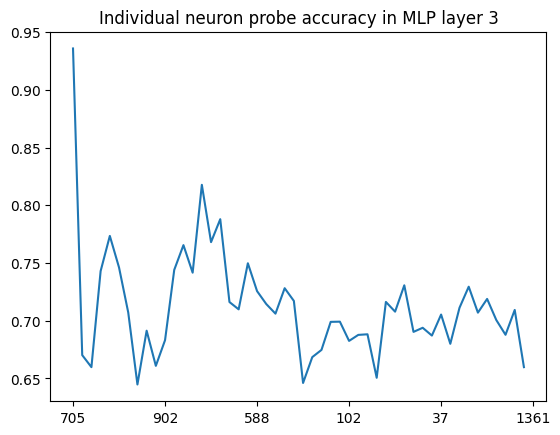

In [52]:
g = sns.lineplot(train_accs.mean(0))
g.set_xticklabels(topk)
g.set_title("Individual neuron probe accuracy in MLP layer 3")

In [53]:
top_k_indices, top_k_scores

(tensor([ 609,  588,  705,  102,  902, 1361,   37,  907, 1715, 1786]),
 tensor([2.3784, 0.6612, 0.6588, 0.6192, 0.6181, 0.6088, 0.5682, 0.5547, 0.5120,
         0.4647]))

## Test ablation performance

In [54]:
french_activation_L3N609 = french_tokens[:, 609]
non_french_activation_L3N609 = non_french_tokens[:, 609]
mean_french_activation_L3N609 = french_tokens[:, 609].mean(0)
mean_non_french_activation_L3N609 = non_french_tokens[:, 609].mean(0)
print("French activation:", mean_french_activation_L3N609.mean(0).item())
print("Non french activation:", mean_non_french_activation_L3N609.mean(0).item())

French activation: 2.338489294052124
Non french activation: -0.06375191360712051


<Axes: ylabel='Count'>

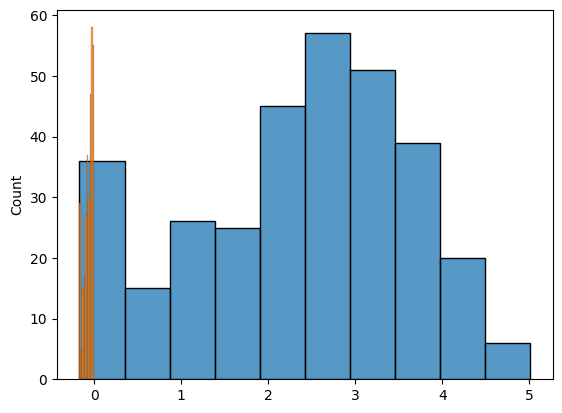

In [55]:
sns.histplot(french_activation_L3N609.cpu().numpy())
sns.histplot(non_french_activation_L3N609.cpu().numpy())

In [56]:
def ablate_neuron_hook(value, hook):
  # Shape [batch pos d_mlp]
  #if hook.layer() == 3:
  value[:, :, 609] = mean_non_french_activation_L3N609
  return value

tokens = model.to_tokens(french[500:532])
print(tokens.shape)
original_loss = model(tokens, return_type="loss")
ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label, ablate_neuron_hook)])

print(f"Full model loss: {original_loss:.6f}")
print(f"Ablated MLP layer loss: {ablated_loss:.6f}")

torch.Size([32, 522])
Full model loss: 6.594291
Ablated MLP layer loss: 6.694791


In [ ]:
# Summary Statistics for KDE dataset on Pythia
# average loss around 3
# loss increase from ablating french neuron around 6%

import math

act_label = f'blocks.3.mlp.hook_post'
batch_size = 32
iterations = 500
average_original_loss = 0
average_ablated_loss = 0

min_original_loss = math.inf
paired_ablated_loss = math.inf

for sample in french:
  tokens = model.to_tokens(sample)
  original_loss = model(tokens, return_type="loss")
  ablated_loss = model.run_with_hooks(tokens, return_type="loss", fwd_hooks=[(act_label, ablate_neuron_hook)])

  if (original_loss < min_original_loss):
    min_original_loss = original_loss
    paired_ablated_loss = ablated_loss
    min_original_loss = original_loss

  average_original_loss += original_loss
  average_ablated_loss += ablated_loss

average_original_loss /= len(french)
average_ablated_loss /= len(french)

print(f"Full model loss: {average_original_loss:.6f}")
print(f"Ablated MLP layer loss: {average_ablated_loss:.6f}")
print(f"% increase: {((average_ablated_loss - average_original_loss) / average_original_loss).item() * 100:.6f}")

print(min_original_loss)
print(paired_ablated_loss)